In [2]:
# Assign directory
import os
import pickle
import matplotlib.patches as patches

BRANDON = '/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/'
YASH = '/Users/yashd/Desktop/hierarchical-bayesian-model-validation/'
HANNAH = ''
ZIXUN = ''

ROOT_DIR = YASH
os.chdir(ROOT_DIR + 'testing-framework/')

from utilities import *
from plot_utilities import *

os.chdir(ROOT_DIR + 'kl-divergence/')

In [3]:
# Grid values for ellipses
r_ellipses = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4]
eta_ellipses = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8]
R_ellipses, Eta_ellipses = np.meshgrid(r_ellipses, eta_ellipses)

# Finer grid values for the contour plot
r_contour = [round_to_sigfigs(i*0.01 + 0.5, 2) for i in range(0, 360)]
eta_contour = [round_to_sigfigs(j*0.02 + 1, 2) for j in range(0, 360)]
R_contour, Eta_contour = np.meshgrid(r_contour, eta_contour)

KstestResult(statistic=0.01858000000000004, pvalue=2.004511133866837e-15, statistic_location=0.9999999999999999, statistic_sign=-1)


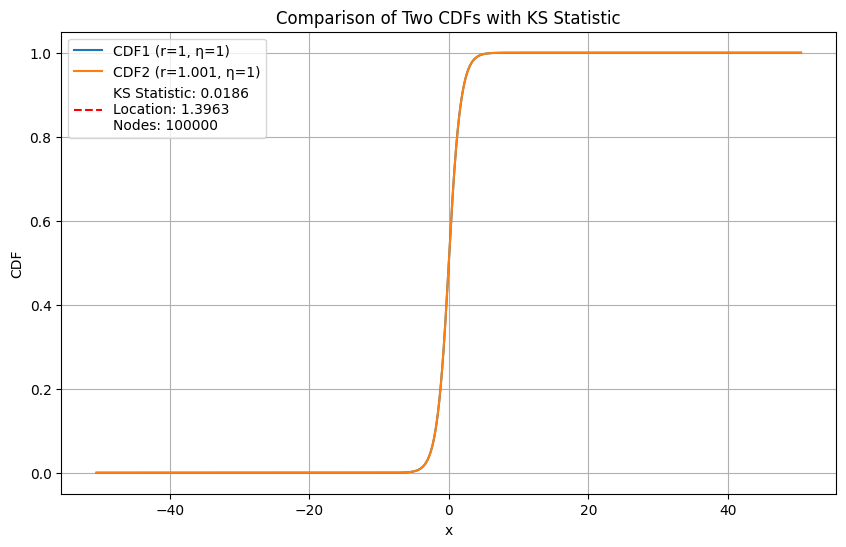

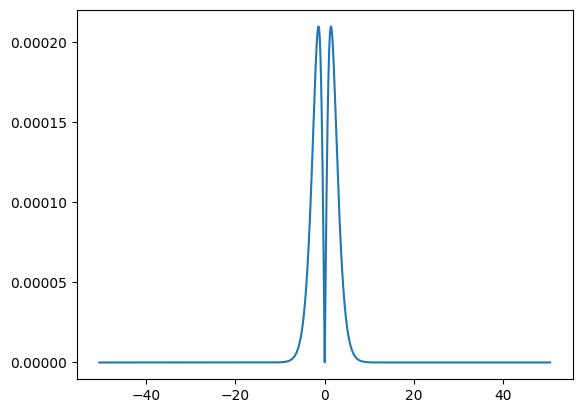

In [22]:
def compute_ksstat_cdfs(params1, params2, n_nodes = 100000, n_samples=500, plot=False, debug=False):

    r1, eta1 = params1
    r2, eta2 = params2
    
    # Compute CDFs
    xs1, cdf1 = compute_prior_cdf(r1, eta1, n_samples=n_samples, return_xs=True, debug=debug)
    xs2, cdf2 = compute_prior_cdf(r2, eta2, n_samples=n_samples, return_xs=True, debug=debug)
    
    # Create a common x-axis for comparison
    xs = np.linspace(min(xs1[0], xs2[0]), max(xs1[-1], xs2[-1]), n_nodes)
    
    # Compute KS statistic
    ks_statistic, p_value = scipy.stats.ks_2samp(cdf1(xs), cdf2(xs))
    
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(xs, cdf1(xs), label=f'CDF1 (r={r1}, η={eta1})')
        plt.plot(xs, cdf2(xs), label=f'CDF2 (r={r2}, η={eta2})')
        
        # Find the point of maximum difference
        diff = np.abs(cdf1(xs) - cdf2(xs))
        max_diff_index = np.argmax(diff)
        max_diff_x = xs[max_diff_index]
        max_diff_y1 = cdf1(max_diff_x)
        max_diff_y2 = cdf2(max_diff_x)
        print(scipy.stats.ks_2samp(cdf1(xs), cdf2(xs)))
        
        # Plot the line representing the KS statistic
        plt.plot([max_diff_x, max_diff_x], [max_diff_y1, max_diff_y2], 'r--', 
                 label=f'KS Statistic: {ks_statistic:.4f}\nLocation: {max_diff_x:.4f}\nNodes: {n_nodes}')
        
        plt.xlabel('x')
        plt.ylabel('CDF')
        plt.title('Comparison of Two CDFs with KS Statistic')
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.plot(xs, diff)
        plt.show()
    return ks_statistic

params1 = (1, 1)  # r0, eta0
params2 = (1.001, 1)  # r1, eta1
ks_stat = compute_ksstat_cdfs(params1, params2, n_nodes = 100000, plot=True)

In [5]:
def deriv_ks_r2(r, eta, delta_r):
    return 1/delta_r**2 * (compute_ksstat_cdfs((r, eta), (r + delta_r, eta)) + compute_ksstat_cdfs((r, eta), (r - delta_r, eta)))

def deriv_ks_r_eta(r, eta, delta_r, delta_eta):
    return 1/(4*delta_r*delta_eta) * (compute_ksstat_cdfs((r, eta), (r + delta_r, eta+delta_eta)) 
                                      - compute_ksstat_cdfs((r, eta), (r + delta_r, eta-delta_eta)) 
                                      - compute_ksstat_cdfs((r, eta), (r - delta_r, eta+delta_eta))
                                      + compute_ksstat_cdfs((r, eta), (r - delta_r, eta - delta_eta)))

def deriv_ks_eta2(r, eta, delta_eta):
    return 1/delta_eta**2 * (compute_ksstat_cdfs((r, eta), (r, eta+delta_eta)) + compute_ksstat_cdfs((r, eta), (r, eta - delta_eta)))

In [6]:
def hessian_ks(r, eta, delta = 0.0001):
    delta_r = delta
    delta_eta = delta
    H = np.array([[deriv_ks_r2(r = r, eta = eta, delta_r = delta_r), deriv_ks_r_eta(r, eta, delta_r = delta_r, delta_eta = delta_eta)],
                  [deriv_ks_r_eta(r = r, eta = eta, delta_r = delta_r, delta_eta = delta_eta), deriv_ks_eta2(r = r, eta = eta, delta_eta = delta_eta)]])
    return H

In [9]:
hessian_ks(1, 1)

array([[5111000.        , -655500.        ],
       [-655500.        , 6062000.00000001]])

In [7]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

Singular Value: 1566163.6904933637, r: 0.5, eta: 1.0
Singular Value: 7181909.6538138315, r: 0.75, eta: 1.0
Singular Value: 4776697.246238322, r: 1.0, eta: 1.0
Singular Value: 2987326.840152549, r: 1.25, eta: 1.0
Singular Value: 7122242.702470505, r: 1.5, eta: 1.0
Singular Value: 7428695.8649012465, r: 1.75, eta: 1.0
Singular Value: 4857991.030940874, r: 2.0, eta: 1.0
Singular Value: 18578070.84666528, r: 2.25, eta: 1.0
Singular Value: 10373369.889310407, r: 2.5, eta: 1.0
Singular Value: 8358580.9871214405, r: 2.75, eta: 1.0
Singular Value: 17706240.67312956, r: 3.0, eta: 1.0
Singular Value: 7791105.788723937, r: 3.25, eta: 1.0
Singular Value: 8318331.008502614, r: 3.5, eta: 1.0
Singular Value: 6282759.870554405, r: 3.75, eta: 1.0
Singular Value: 5035888.627572696, r: 4.0, eta: 1.0
Singular Value: 1428940.4776857677, r: 0.5, eta: 1.5
Singular Value: 2571807.143234067, r: 0.75, eta: 1.5
Singular Value: 12669724.116373971, r: 1.0, eta: 1.5
Singular Value: 3127199.771354382, r: 1.25, eta: 

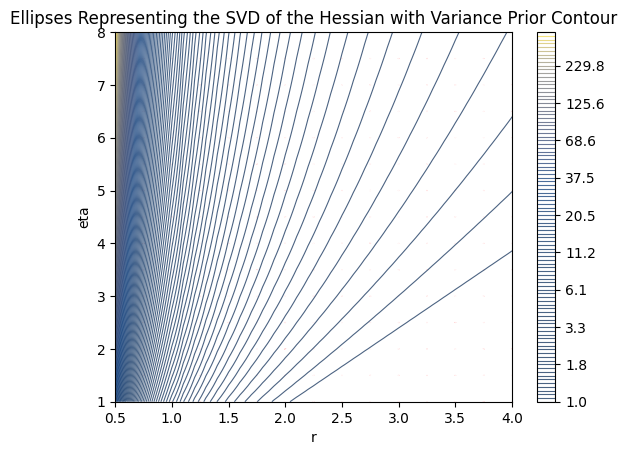

In [8]:
# Grid values for ellipses
r_ellipses = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4]
eta_ellipses = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8]

R_ellipses, Eta_ellipses = np.meshgrid(r_ellipses, eta_ellipses)

# Finer grid values for the contour plot
r_contour = [round_to_sigfigs(i*0.01 + 0.5, 2) for i in range(0, 360)]
eta_contour = [round_to_sigfigs(j*0.02 + 1, 2) for j in range(0, 360)]
R_contour, Eta_contour = np.meshgrid(r_contour, eta_contour)

# Initialize the plot
fig, ax = plt.subplots()
ax.set_xlim(np.min(r_ellipses), np.max(r_ellipses))
ax.set_ylim(np.min(eta_ellipses), np.max(eta_ellipses))

scale_factor = 0.01
pos_list = []
singular_values = []

# Directory for storing Hessian matrices
hessian_dir = 'hessian_matrices_ks'
os.makedirs(hessian_dir, exist_ok=True)

# Function to generate a file path for a given (r, eta) pair
def get_hessian_path(r_val, eta_val):
    return os.path.join(hessian_dir, f'hessian_R{r_val}_Eta{eta_val}.pkl')

# Function to calculate variance_prior
def variance_prior(r, eta, scale=1):
    beta = (eta + 1.5) / r
    var_prior = scale * scipy.special.gamma(beta + 1 / r) / scipy.special.gamma(beta)
    return var_prior

# Initialize grid for var_prior values for the contour plot
var_prior_values = np.zeros_like(R_contour)

# Loop through R_contour and Eta_contour for the contour plot
for i in range(len(r_contour)):
    for j in range(len(eta_contour)):
        var_prior_values[i, j] = variance_prior(R_contour[i, j], Eta_contour[i, j])

# Loop through R_ellipses and Eta_ellipses for the ellipses
for i in range(len(r_ellipses)):
    for j in range(len(eta_ellipses)):
        hessian_path = get_hessian_path(R_ellipses[i, j], Eta_ellipses[i, j])
        
        # Check if the Hessian matrix is already stored
        if os.path.exists(hessian_path):
            with open(hessian_path, 'rb') as f:
                H = pickle.load(f)
        else:
            # Calculate the Hessian matrix if not already stored
            H = hessian_ks(R_ellipses[i, j], Eta_ellipses[i, j])
            # Store the Hessian matrix in a pickle file
            with open(hessian_path, 'wb') as f:
                pickle.dump(H, f)
        
        pos_list.append(is_pos_def(H))
        U, s, Vt = np.linalg.svd(H)
        for singular_value in s:
            if R_ellipses[i, j] != 0.25:
                singular_values.append((singular_value, R_ellipses[i, j], Eta_ellipses[i, j]))
        angle = np.arctan2(U[0, 1], U[0, 0]) * 180 / np.pi  # Convert radian to degree
        width, height = scale_factor / np.sqrt(s[0]), scale_factor / np.sqrt(s[1])  # Axis lengths
        ellipse = patches.Ellipse((R_ellipses[i, j], Eta_ellipses[i, j]), width, height, angle=angle, edgecolor='red', facecolor='none')
        ax.add_patch(ellipse)
        print(f'Singular Value: {singular_value}, r: {R_ellipses[i, j]}, eta: {Eta_ellipses[i, j]}')

# Sort the singular values in ascending order
singular_values.sort(key=lambda x: x[0])

# Print the sorted singular values and corresponding r, eta pairs
for value, r_val, eta_val in singular_values:
    print(f'Singular Value: {value}, r: {r_val}, eta: {eta_val}')

print(pos_list)

# Set upper bound for variance
upper_bound = 5

# Define contour levels using var_prior_values from the original grid
exp_levels = np.logspace(0, np.log10(np.max(var_prior_values)), 100)

# Overlay contour plot with reduced opacity and no labels
contour = plt.contour(R_contour, Eta_contour, var_prior_values, levels=exp_levels, cmap='cividis', alpha=0.7, linewidths=0.8)
plt.colorbar(contour)

# Title and labels
plt.title('Ellipses Representing the SVD of the Hessian with Variance Prior Contour')
plt.xlabel('r')
plt.ylabel('eta')
plt.show()
